#FAST SABR CALIBRATION TO MARKET IMPLIED VOLATILITY SURFACES

Students: Nam NGUYEN, Johan MACQ, Jeremy MARCK, Antoine LEFEBVRE

Reference article: *Deep Learning Volatility: a deep neural network perspective on pricing and calibration in (rough) volatility models*, Horvath, Muguruza and Tomas (2019).

Goal: calibrate an SABR model to a market implied volatility surface as fast and precisely as possible.

**OUTLINE:**

**I. Creation of SABR implied volatility surfaces**
1. SABR implied volatility
2. SABR implied volatility surface
3. Creation of the learning dataset


**II. Neural network approximation of volatility surfaces**
1. Neural network architecture using TensorFlow
2. Tuning the neural network
3. Prediction errors from the optimized network

**III. SABR calibration to market surfaces**
1. Calibration procedure
2. Calibration error analysis

Context is given at the beginning of each section. More detailed explanations are provided thoughout the code. Should you have any question on our work, feel free to contact us.


In [1]:
# Import useful packages and functions

%tensorflow_version 1.x # to choose tf1.
import tensorflow as tf
print(tf.__version__)
import numpy as np
import pandas as pd
import math
import time
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.image as mpimg
import seaborn as sns

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # to choose tf1.`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# I. Creation of SABR implied volatility surfaces:

In this section, we generate approximately 40,000 volatility surfaces from different sets of SABR parameters. These data/surfaces will be used in section II to feed the neural network approximator.

There are two ways of generating an implied volatlity from a set of SABR parameters:
- by Monte-Carlo simulation;
- by using the closed-form formula derived by Hagan, Kumar, Lesniewski and Woodward in their paper *Managing Smile Risk*.

The first method is accurate (provided the paths of the underlying asset and of the stochastic volatility are correctly computed) but very time-expensive. The second is almost instantaneous but is an approximation that best holds at the money. As a result, we will generate our data using the closed-form formula but only for a narrow range of $S_0/K$, that is $S_0/K \in [0.85, 1.15]$.

Another important point concerns the parameter $\beta$. It affects the skewness of the volatility surface, which does not evolve quickly over time in interest rates markets. In practice, using Hagan's formula, $\beta$ is estimated by a linear regression on a time series of logs of at-the-money volatilities and logs of forward rates. As a consequence, we will fix $\beta = 0.5$ in this notebook. Parameter estimation in section III will therefore concern $v_0$, $\alpha$ and $\rho$.

## I.1 SABR implied volatility

The function `SABR_implied_vol` returns the SABR implied volatility, which is the value of the lognormal volatility parameter in Black's model that forces the Black valuation formula to match the SABR price. This is the formula of Hagan and al.

In [2]:
def SABR_implied_vol(v0, alpha, beta, rho, s0, K, T):
    z = alpha/v0*(s0*K)**((1-beta)/2)*np.log(s0/K)
    chi_z = np.log(((1-2*rho*z+z**2)**0.5+z-rho)/(1-rho))
    A = (s0*K)**((1-beta)/2)*(1 + (1-beta)**2/24*np.log(s0/K)**2 + (1-beta)**4/1920*np.log(s0/K)**4)
    B = 1 + T*( (1-beta)**2/24*v0**2/(s0*K)**(1-beta) + 0.25*rho*beta*alpha*v0/(s0*K)**((1-beta)/2) + (2-3*rho**2)/24*alpha**2 )
    sigma = v0/A*z/chi_z*B
    return(sigma)

# parameters
s0, v0, alpha, beta, rho, K, T = 0.03, 0.03, 0.5, 0.5, 0.1, 0.031, 1
# SABR implied vol
SABR_implied_vol(v0, alpha, beta, rho, s0, K, T)

0.17664805487481475

## I.2 SABR implied volatility surface

An SABR volatility surface is defined by a set ($v_0$, $\alpha$, $\beta$, $\rho$, $S_0$) of SABR parameters and by the associated SABR implied volatilities on a grid $(K_i, T_j)_{i=1,..n;j=1,..m}$ of strikes and maturities.

In the rest of this notebook, we will consider the following grid:
- 10 strikes $K_i$ linearly distributed between 2.75% and 3.25%;
- 8 maturities $T_j$ ranging from 1 month to 2 years.

We chose this grid by looking at quoted swaptions.

In [3]:
# Define and display the grid

K = np.linspace(2.75/100, 3.25/100, 10) 
T = np.asarray([1/12, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 2])
print('Strikes set:', K)
print(' ')
print('Maturities set:', T)

Strikes set: [0.0275     0.02805556 0.02861111 0.02916667 0.02972222 0.03027778
 0.03083333 0.03138889 0.03194444 0.0325    ]
 
Maturities set: [0.08333333 0.25       0.5        0.75       1.         1.25
 1.5        2.        ]


The function `SABR_vol_surface` returns a volatility surface (as a list) given a set of SABR parameters and a grid.

In [0]:
def SABR_vol_surface(v0, alpha, beta, rho, s0, K, T):
    vols = []
    for i in range(len(K)):
        for j in range(len(T)):
            vols.append(SABR_implied_vol(v0, alpha, beta, rho, s0, K[i], T[j]))
    return(vols)

The function `plot_surfaces` plots 3D volatility surfaces.

In [0]:
def plot_surfaces(vol_surfaces, K, T):
  # vol_surfaces: list of SABR volatility surfaces on same grid K, T
  X , Y = np.meshgrid(K, T)
  fig = plt.figure(figsize=plt.figaspect(0.25))
  for i in range(len(vol_surfaces)):
    vol_surface = vol_surfaces[i]
    z = [[0,0,0,0,0,0,0,0]]
    for j in range(len(K)):
      z = np.concatenate((z,[vol_surface[j*len(T):(j+1)*len(T)]]))
    z = z[1:,]
    z = np.transpose(z)
    ax = fig.add_subplot(1, 2, i+1, projection='3d')
    surf = ax.plot_surface(X, Y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.set_xlabel('Strike')
    ax.set_ylabel('Maturity')
    ax.set_zlabel('Volatility')
  plt.show()

IMPLIED SABR VOLATILITY SURFACE
SABR parameters: s0 =  0.03 , v0 =  0.03 , alpha =  0.6 , beta =  0.5 , rho =  0.2


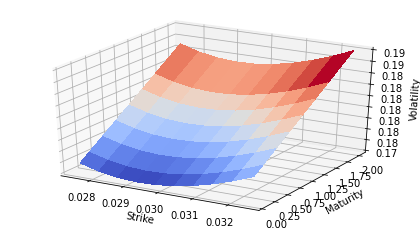

In [6]:
# plot an SABR implied volatility surface

s0, v0, alpha, beta, rho = 0.03, 0.03, 0.6, 0.5, 0.2
K = np.linspace(2.75/100, 3.25/100, 10) 
T = np.asarray([1/12, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 2])
vol_surface = SABR_vol_surface(v0, alpha, beta, rho, s0, K, T)
print("IMPLIED SABR VOLATILITY SURFACE")
print("SABR parameters: s0 = ", s0, ", v0 = ", v0, ", alpha = ", alpha, ", beta = ", beta, ", rho = ", rho)
plot_surfaces([vol_surface], K, T)

## I.3 Creation of the learning dataset

We build a learning dataset by generating approximately 40,000 sets of SABR parameters (that will serve as inputs to the neural network) and their associated volatility surfaces (that will serve as outputs to the neural network).

Since $\beta$ is set to 0.5, the inputs of the neural network are of the form ($v_0$, $\alpha$, $\rho$, $S_0$). The outputs are generated with the inputs ($v_0$, $\alpha$, $\beta = 0.5$, $\rho$, $S_0$).

In [7]:
# Creation of inputs

v0 = np.linspace(1/100, 4/100, 14)
alpha = np.linspace(0.2, 0.6, 14)
beta = 0.5
rho = np.linspace(-0.5, 0.5, 14)
s0 = np.random.uniform(2.75/100, 3.25/100, 15)
inputs = [] # list of inputs
for v in v0:
    for a in alpha:
      for r in rho:
        for s in s0:
          inputs.append([v, a, r, s])
print('First input: ', inputs[0])


# Creation of outputs (1/2 minutes execution time)

outputs = [] # list of outputs
for theta in inputs:
    outputs.append(SABR_vol_surface(theta[0], theta[1], beta, theta[2], theta[3], K, T))
print('First output', outputs[0])

First input:  [0.01, 0.2, -0.5, 0.030673880939312757]
First output [0.06478864756818103, 0.06480360904902605, 0.06482605127029356, 0.06484849349156106, 0.06487093571282858, 0.06489337793409608, 0.0649158201553636, 0.0649607045978986, 0.06330561390257505, 0.0633202677355652, 0.06334224848505043, 0.06336422923453566, 0.06338620998402086, 0.06340819073350609, 0.06343017148299132, 0.06347413298196178, 0.061877693187210266, 0.06189204971379346, 0.06191358450366824, 0.06193511929354303, 0.06195665408341779, 0.06197818887329258, 0.06199972366316736, 0.06204279324291693, 0.060507403051153805, 0.060521473377291087, 0.060542578866497006, 0.06056368435570293, 0.060584789844908865, 0.06060589533411479, 0.06062700082332071, 0.060669211801732556, 0.05919762912949126, 0.059211425207268006, 0.05923211932393314, 0.05925281344059826, 0.059273507557263384, 0.05929420167392851, 0.05931489579059364, 0.059356284023923886, 0.05795158120315784, 0.057965115903456384, 0.05798541795390421, 0.058005720004352036, 

Inputs and outputs are then normalized as in Horvath and al.


In [0]:
# inputs normalization

inputs = pd.DataFrame(np.asarray(inputs), columns = ['v0', 'alpha', 'rho', 's0'])
theta_M = np.array([]) # keep track of normalization parameters
theta_m = np.array([])
for col in inputs.columns:
    M = max(inputs[col])
    m = min(inputs[col])
    inputs[col] = (2*inputs[col] - (M + m))/(M - m)
    theta_M = np.append(theta_M, M) 
    theta_m = np.append(theta_m, m)


# outputs normalization

outputs = pd.DataFrame(np.asarray(outputs))
mn = np.array([]) # keep track of normalization parameters
st = np.array([])
for col in outputs.columns:
    m = outputs[[col]].mean()
    s = outputs[[col]].std()
    outputs[[col]] = (outputs[[col]]-m)/s
    mn = np.append(mn, m)
    st = np.append(st, s)

In the cell above, we kept track of the normalization parameters. This will help juggle between normalized data and real data. Below are four useful functions that normalize or "denormalize" the inputs and outputs.

In [0]:
def denormalize_input(inp):
  return(0.5*(inp*(theta_M-theta_m)+(theta_M+theta_m)))

def normalize_input(inp):
  return((2*inp-(theta_M+theta_m))/(theta_M-theta_m))

def denormalize_output(out):
  return(out*st+mn)

def normalize_output(out):
  return((out-mn)/st)

Here are the training, validation and tests datasets:

In [0]:
# concatenate and shuffle inputs and outputs
data = np.concatenate((inputs, outputs),axis = 1)
np.random.shuffle(data)

# define training set size; valid and test sets are split between the remaining data
n = len(data)
nb_param = 4 # v0, alpha, rho, s0 are the 4 inputs of the network
train_size = 0.9
idx_train = round(n*train_size)
idx_valid = round(n*train_size)+round(n*(1-train_size)/2) 

# train, validation and test sets (used for training the network in section II)
X_train, X_valid, X_test = data[:idx_train,:nb_param], data[idx_train:idx_valid,:nb_param], data[idx_valid:,:nb_param]
Y_train, Y_valid, Y_test = data[:idx_train,nb_param:], data[idx_train:idx_valid,nb_param:], data[idx_valid:,nb_param:]

In section II, we will perform the neural network optimization with the normalized $X$ and $Y$  datasets. We also introduce $I$ and $O$ datasets, which are the "denormalized"/real-valued corresponding inputs and outputs. We will use them in section III when performing the calibration task.

In [0]:
I_train, I_valid, I_test = denormalize_input(X_train), denormalize_input(X_valid), denormalize_input(X_test)
O_train, O_valid, O_test = denormalize_output(Y_train), denormalize_output(Y_valid), denormalize_output(Y_test)

# II. Neural network approximation of volatility surfaces

In this section we present a neural network model to valuate volatility surfaces that can be obtained with a SABR model. We implement functions used for building the network, valuating its output (i.e. a volatility surface) and for training the network. We compare several network architectures performance and chose the best among the candidates. The neural network is built from scratch using a low-level TensorFlow framework.

## II.1. Neural network architecture using TensorFlow


The function `construct_densenn_graph` builds a neural network given the parameters provided in argument, namely input and ouput dimension, number of hidden layers, activation function to be used on hidden layers and activation function to be used on the output layer.

For each layer, weights are initialized with a gaussian distribution $\mathcal{N}\left(0,\ \frac{2}{\sqrt{n_{layerInputs}+n_{layerOutputs}}}\right)$ for an optimal initialization. Biases are initialized to zero.

We chose the so-called MSE loss function.

Tensorflow AdamOptimizer is used to perform the gradient descent.

In [0]:
def construct_densenn_graph(input_dim, output_dim, num_hidden_layers, num_hidden_units, activation,final_activation): 
    # Building a graph which will be run during the execution phase.
    g = tf.Graph()
    with g.as_default():
        X = tf.placeholder(tf.float32, shape = (None, input_dim), name = 'X')
        Y = tf.placeholder(tf.float32, shape = (None, output_dim), name = 'Y')
        learningRate = tf.placeholder(tf.float32, shape = [],name = 'learningRate')
        # Initialization.
        weights, biases = [], []
        for i in range(num_hidden_layers+1): #weights and biais matrix construction
            dim_prev = input_dim if i==0 else num_hidden_units
            num_units = output_dim if i==num_hidden_layers else num_hidden_units
            weights.append(tf.get_variable('weights/W'+str(i), 
                                            shape=(num_units, dim_prev), 
                                            dtype=tf.float32, 
                                            initializer=tf.random_normal_initializer(mean=0, stddev=np.sqrt(2)*np.sqrt(2/(num_units+dim_prev)) ))) #optimal initialization, see ML book
            biases.append(tf.get_variable('biases/b'+str(i), shape=(num_units, 1), 
                                            dtype=tf.float32, 
                                            initializer=tf.zeros_initializer()))
        out = tf.transpose(X)
        # Building the fundation of the network.
        for i in range(num_hidden_layers+1): #output construction
            if i < num_hidden_layers: #activation function for the hidden layers
                if activation == None:
                    out = tf.matmul(weights[i], out)+biases[i]
                else:
                    out = activation(tf.matmul(weights[i], out)+biases[i])
            else: #activation function for the output layer
                if final_activation == None:
                    out = tf.matmul(weights[i], out)+biases[i]
                else:
                    out = final_activation(tf.matmul(weights[i], out)+biases[i])
        # Getting the ouput of the network.
        out = tf.identity(out, name='out')
        # Using the MSE loss function.
        loss_fct = tf.reduce_mean((tf.transpose(out) - Y)**2, name='loss_fct')  # compute loss function
        # Gradient descent optimizer.
        gradient_step = tf.train.AdamOptimizer(learning_rate=learningRate).minimize(loss_fct, var_list=weights+biases, name='gradient_step') # compute gradient descent and update weights and biases
    return g

The function `eval_densenn` computes a volatility surface with the network $g$ given a set of inputs $X_{in}$, weights and biases.

In [0]:
def eval_densenn(g, X_in, weights_fitted, biases_fitted):
    X = g.get_tensor_by_name('X:0')
    out = g.get_tensor_by_name('out:0')
    weights = g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='weights')
    biases = g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='biases')
    feed_dict = {k: v for k, v in zip([X,]+weights+biases, [X_in,]+weights_fitted+biases_fitted)}
    with tf.Session(graph=g) as sess:
        out = sess.run(out, feed_dict=feed_dict)
    return out.T

The function `fit_densenn_model` is the trainer of a given network $g$. Provided a train data set ($X_{\text{train}},Y_{\text{train}}$), it optimizes the network until the error is below $eps$ or the number of iterations is above $max\_iter$. The learning rate decreases every 100 epochs with the following rule: $\alpha_t = 0.95*\alpha_{t-1}$.

The function returns the matrix of weights and biases.

In [0]:
def fit_densenn_model(g, X_train, Y_train, eps, max_iter,learning_rate):
    X = g.get_tensor_by_name('X:0')
    Y = g.get_tensor_by_name('Y:0')
    learningRate = g.get_tensor_by_name('learningRate:0')

    gradient_step = g.get_operation_by_name('gradient_step')
    loss_fct = g.get_tensor_by_name('loss_fct:0')
    weights = g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='weights')
    biases = g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='biases')

    #saver = tf.train.Saver()

    with tf.Session(graph=g) as sess:
        sess.run(tf.global_variables_initializer())
        err = np.inf
        i = 0

        while (err >= eps) and (i < max_iter):
            sess.run(gradient_step, feed_dict={X: X_train, Y: Y_train, learningRate: learning_rate})
            err = sess.run(loss_fct, feed_dict={X: X_train, Y: Y_train})
            i += 1
            if i%100==0:
              learning_rate *= 0.95                  # decreasing learning rate every 100 epochs
        weights_fitted = sess.run(weights)
        biases_fitted = sess.run(biases)

    return weights_fitted, biases_fitted

## II.2 Tuning the neural network

This section is dedicated to the tuning of the Neural Network i.e. optimizing our network by trying to get the best performance (i.e. the lowest error). We also consider execution time as a central point in optimizing our network and try to reach an equilibrium between good performance and execution time.

We train different architectures on 5000 data and look at the MSE error on the validation set. The MSE metric is better than any other relative metric because it does not diverge (our volatility surfaces are normalized and most of them have values close to zero).

### II.2.a) Tuning number of hidden layers and hidden units



In [15]:
eps = 1e-6
max_iter = 2000
learning_rate = 0.01
n_hidden_layer = [2, 3, 4]
n_hidden_unit = [25, 30, 35]
for l in n_hidden_layer:
  for u in n_hidden_unit:
    nn = construct_densenn_graph(X_train.shape[1],Y_train.shape[1], l, u, activation=tf.nn.elu, final_activation=None) # build network
    t0 = time.clock()
    weights_fitted, biases_fitted = fit_densenn_model(nn, X_train[:5000,], Y_train[:5000,], eps, max_iter, learning_rate) # train network
    t1 = time.clock()
    Y_valid_pred = eval_densenn(nn, X_valid, weights_fitted, biases_fitted) # evaluate on validation set
    val_err = np.mean((Y_valid_pred - Y_valid)**2, axis = 1) # contains average squared error for each output
    val_err = np.mean(val_err) # global average squared error
    print('Model: (', l, ' hidden layers, ', u, ' hidden units )')
    print('MSE on validation set: ', val_err)
    print('Execution time: ', t1-t0)
    print('*'*50)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: ( 2  hidden layers,  25  hidden units )
MSE on validation set:  9.252962356637363e-05
Execution time:  63.15633700000001
**************************************************
Model: ( 2  hidden layers,  30  hidden units )
MSE on validation set:  8.922371089363799e-05
Execution time:  66.372599
**************************************************
Model: ( 2  hidden layers,  35  hidden units )
MSE on validation set:  8.770734209765544e-05
Execution time:  70.84114
**************************************************
Model: ( 3  hidden layers,  25  hidden units )
MSE on validation set:  7.57958666621075e-05
Execution time:  74.31183699999997
**************************************************
Model: ( 3  hidden layers,  30  hidden units )
MSE on validation set:  7.266768025302568e-05
Execution time:  78.38544399999995
**************************************************
Model: ( 3  hidden layers,  3

We can see that a very good approximation is obtained with a 3 layers and 35 units network. Increasing the number of layers to 4 improves a little the performance but not meaningfully, and takes much more time to train.

For the rest of our work, we will then chose a 3 layers and 35 units network.

### II.2.b) Tuning activation functions


We will test three different activation functions associated with the best combination from before.
1.   $\text{relu}(x) = \max(0,x)$.
2.   $\text{elu}(x) = x$ if $x>0$ and $= \alpha\left[e^{x} - 1\right]$ else.
3.   $\text{softplus}(x) = \ln\left(1 + e^{x}\right)$.

For the final activation function, we also authorize the identity function.



In [16]:
# best number of hidden layers and hidden units as seen in section II.2.a
n_hidden_layer = 3
n_hidden_unit = 35

# activation functions to try
activation_list = [tf.nn.relu, tf.nn.elu, tf.nn.softplus]
final_activation_list = [None, tf.nn.relu, tf.nn.elu, tf.nn.softplus]
for act in activation_list:
    for final_act in final_activation_list:
        nn = construct_densenn_graph(X_train.shape[1],Y_train.shape[1], n_hidden_layer, n_hidden_unit, activation=act, final_activation=final_act)
        t0 = time.clock()
        weights_fitted, biases_fitted = fit_densenn_model(nn, X_train[:5000,], Y_train[:5000,], eps, max_iter, learning_rate) # train network
        t1 = time.clock()
        Y_valid_pred = eval_densenn(nn, X_valid, weights_fitted, biases_fitted) # evaluate on validation set
        val_err = np.mean((Y_valid_pred - Y_valid)**2, axis = 1) # contains average squared error for each output
        val_err = np.mean(val_err) # global average squared error
        print('Model: (', act, ' activation, ', final_act, ' final activation )')
        print('MSE on validation set: ', val_err)
        print('Execution time: ', t1-t0)
        print('*'*50)   

Model: ( <function relu at 0x7f54ef32ff28>  activation,  None  final activation )
MSE on validation set:  0.00011719280913340628
Execution time:  76.15241000000003
**************************************************
Model: ( <function relu at 0x7f54ef32ff28>  activation,  <function relu at 0x7f54ef32ff28>  final activation )
MSE on validation set:  0.5583186723963135
Execution time:  78.45242500000006
**************************************************
Model: ( <function relu at 0x7f54ef32ff28>  activation,  <function elu at 0x7f54ef3466a8>  final activation )
MSE on validation set:  0.03503098571849536
Execution time:  84.89921200000003
**************************************************
Model: ( <function relu at 0x7f54ef32ff28>  activation,  <function softplus at 0x7f54ef30b488>  final activation )
MSE on validation set:  0.46900883908628876
Execution time:  93.43792500000006
**************************************************
Model: ( <function elu at 0x7f54ef3466a8>  activation,  None

We can see that the best performance are obtained, by far, with an activation function set to Elu function and no activation for the output layer.

### II.2.c) Training the optimal network

We previously illustrated how we proceeded for choosing the optimal neural network. Below we train the network that gave the best results to our knowledge.

In [0]:
# learning parameters
eps = 1e-6
max_iter = 3000
learning_rate = 0.01

# number of hidden layers and units
n_hidden_layer = 3
n_hidden_unit = 35

# activation functions
act = tf.nn.elu
final_act = None

# tuning the chosen architecture
opt_nn = construct_densenn_graph(X_train.shape[1],Y_train.shape[1], n_hidden_layer, n_hidden_unit, activation=act, final_activation=final_act)
opt_weights, opt_biases = fit_densenn_model(opt_nn, X_train, Y_train, eps, max_iter, learning_rate)

## II.3 Prediction errors from the optimized network 

Let's now have a look at the error of our optimized neural network on both validation and test sets.

We introduce the function `plot_heatMap`that displays a heat map of error on the grid.

In [0]:
def plot_heatMap(error, K, T): # error: array of errors over the grid
  z = [[0,0,0,0,0,0,0,0,0,0]]
  for i in range(int(len(error)/10)):
    z = np.concatenate((z,[error[i*10:(i+1)*10]]))
  z = z[1:,]
  x_labels = np.around(K*100, decimals = 2)
  y_labels = np.around(T, decimals = 2)
  ax = sns.heatmap(z, xticklabels = x_labels, yticklabels = y_labels)
  ax.set_xlabel('Strike')
  ax.set_ylabel('Maturity')
  plt.show()

Error on the validation set:


Validation MSE per grid point:


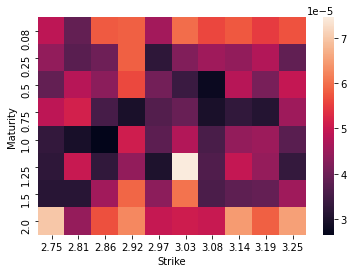

Average validation MSE:  4.4950889896336926e-05


In [19]:
Y_valid_pred = eval_densenn(opt_nn, X_valid, opt_weights, opt_biases) # predictions from X_valid inpu
valid_err = np.mean((Y_valid_pred - Y_valid)**2, axis = 0) # contains average squared error per grid point

print('Validation MSE per grid point:')
plot_heatMap(valid_err, K, T)

print('Average validation MSE: ', np.mean(valid_err))

Error on the test set:

Test MSE per grid point:


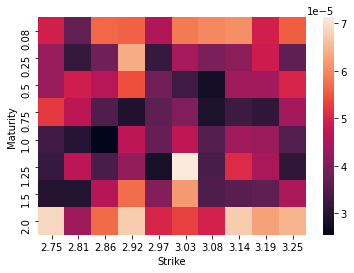

Average test MSE:  4.43936852138849e-05


In [20]:
Y_test_pred = eval_densenn(opt_nn, X_test, opt_weights, opt_biases) # predictions from X_valid inpu
test_err = np.mean((Y_test_pred - Y_test)**2, axis = 0) # contains average squared error per grid point

print('Test MSE per grid point:')
plot_heatMap(test_err, K, T)

print('Average test MSE: ', np.mean(test_err))

There is no sign of overfitting. Next we display 5 predicted surfaces in front of their associated true surfaces, as well as the error heatmaps.

********************** Plot n° 1 **********************
 
Predicted and true surfaces:


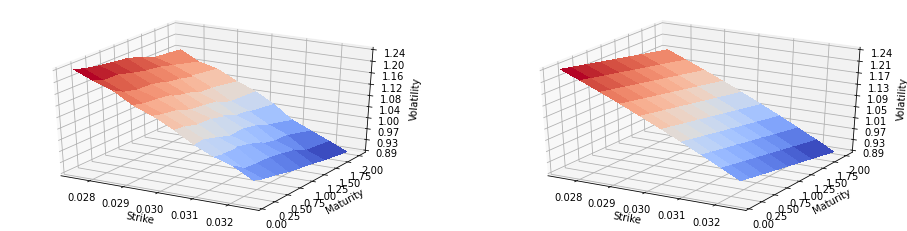

 
MSE per grid point: 
 


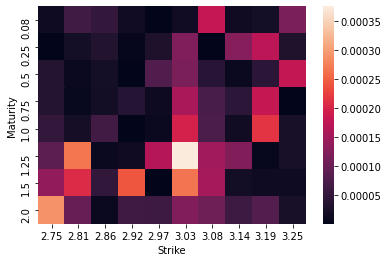

Average MSE:  7.592525073276069e-05
 
 
********************** Plot n° 2 **********************
 
Predicted and true surfaces:


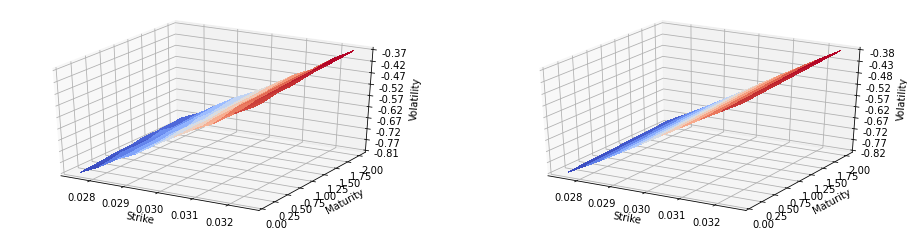

 
MSE per grid point: 
 


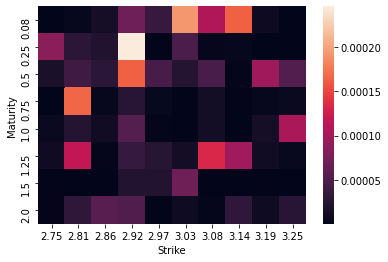

Average MSE:  3.503005149526978e-05
 
 
********************** Plot n° 3 **********************
 
Predicted and true surfaces:


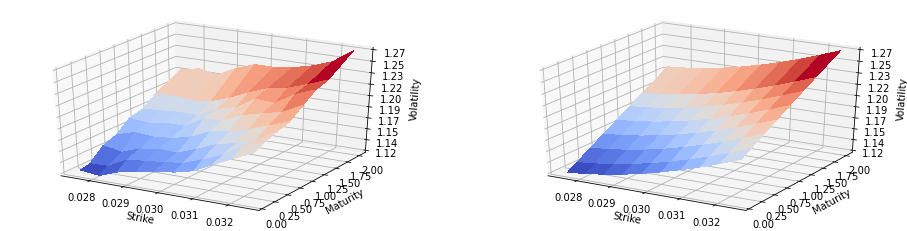

 
MSE per grid point: 
 


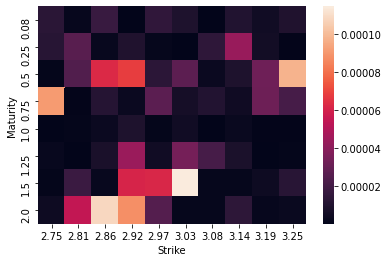

Average MSE:  1.8425818582056543e-05
 
 
********************** Plot n° 4 **********************
 
Predicted and true surfaces:


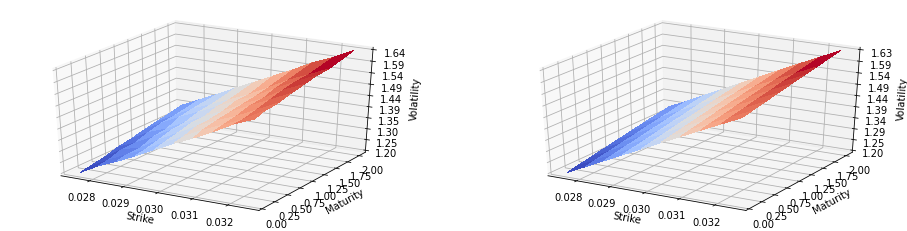

 
MSE per grid point: 
 


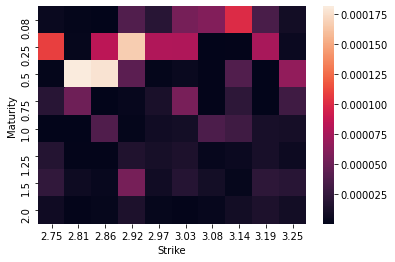

Average MSE:  2.6265373245922908e-05
 
 
********************** Plot n° 5 **********************
 
Predicted and true surfaces:


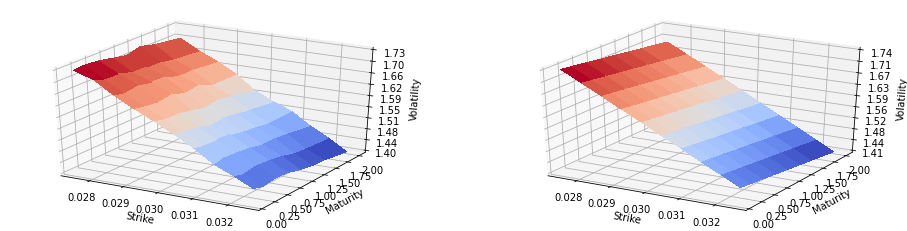

 
MSE per grid point: 
 


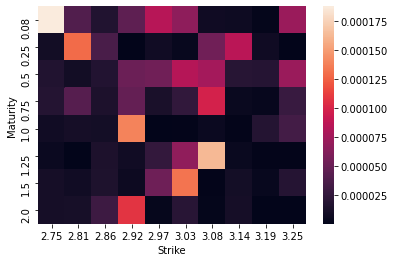

Average MSE:  3.2045088373562756e-05
 
 


In [21]:
nb_plot = 5
for i in range(nb_plot):   
    s1 = Y_test_pred[i,:] # predicted surface
    s2 = Y_test[i,:] # true surface
    err = (s1 - s2)**2 # MSE
    print('*'*22, 'Plot n°', i+1,'*'*22)
    print(' ')
    print('Predicted and true surfaces:') 
    plot_surfaces([s1, s2], K, T)
    print(' ')
    print('MSE per grid point: ')
    print(' ')
    plot_heatMap(err, K, T)
    print('Average MSE: ', np.mean(err))
    print(' ')
    print(' ')

We can see that the network is able to reproduce different forms of surface. It struggles the most with surface having strong skew and term structure.

Now that we have tuned our network, we introduce the function `real_nn` that takes non-normalized parameters as inputs and returns the associated non-normalized surface predicted by the optimized network.



In [0]:
def real_nn(inp):
  # inp: non-normalized np.array([v0, alpha, rho, s0])
  inp = normalize_input(inp) # normalize input to feed nn
  out = eval_densenn(opt_nn, np.array([inp]), opt_weights, opt_biases)[0] #using opt_nn to compute the output
  out = denormalize_output(out) # denormalize output of nn
  return(out)

# III. SABR calibration to market surfaces

Given the current underlying value $S_0$, calibration to a market volatility surface consists in finding parameters $v_0$, $\alpha$, $\rho$ that minimize the distance between this surface and the surface predicted by the neural network. We will perform this minimization task via built-in functions from scipy.optimize package.

Since the calibration is done on real data, we will work with the optimal network `real_nn` and the datasets $I$ and $O$ (introduced at the end of section I) corresponding to non-normalized/real-valued inputs/parameters and outputs/surfaces.

## III.1 Calibration procedure

The function `calibration_loss` is the function we want to minimize. It computes the MSE between an observed market surface and the surface predicted by the network for the given set of parameters. Note that *parameters* is ($v_0$, $\alpha$, $\rho$) we are looking for and that $S_0$ is observed.

In [23]:
def calibration_loss(parameters, s0, surface_obs):
    parameters = np.append(parameters, s0) 
    surface_pred = real_nn(parameters)
    error = np.mean((surface_pred - surface_obs)**2)
    return(error)

parameters = I_test[0][0:3] # v0, alpha, rho
s0 = I_test[0][3]
surface_obs = O_test[0]
calibration_loss(parameters, s0, surface_obs) # the loss will be small because the parameters are already calibrated here

2.2254707829235907e-07

Here comes the calibration function that estimates parameters from observed surface and $S_0$. This function performs gradient descent of `calibration_loss` function. The main difficulty is that the neural network we built is not a convex function. As a result, we might easily get stuck in a local minimum. We partly address this issue by randomly drawing a number $n_{guesses}$ of initial guesses of the optimal parameters. More precisely, we perform $n_{guesses}$ gradient descents with different initial conditions and keep the parameters that led to the lowest local minimum. We also set bounds on each of the parameters, corresponding to the bounds we used to generate the inputs. Clearly, the more the number of initial guesses, the more accurate is the calibration. However, the more the number of initial guesses, the more time-consuming the calibration. In practice, one can accelerate the calibration by looking at calibrated parameters of previous days. Below, we set the number of guesses to 30, which corresponds to a calibration time of around 10 seconds. 

In [24]:
def calibrate(s0, surface_obs, n_guesses):

    # parameter bounds (the same as the ones we used to generate the data in section I)
    v0_min, v0_max = 0.01, 0.04
    alpha_min, alpha_max = 0.2, 0.6
    rho_min, rho_max = -0.5, 0.5
    bounds = ((v0_min, v0_max), (alpha_min, alpha_max), (rho_min, rho_max))

    # initial parameter guesses
    v0 = np.random.uniform(v0_min, v0_max, n_guesses)
    alpha = np.random.uniform(alpha_min, alpha_max, n_guesses)
    rho = np.random.uniform(rho_min, rho_max, n_guesses)
    initial_guesses = np.array([v0, alpha, rho]).T

    # perform the calibration for all the initial guesses
    loss = [] 
    params = []
    for x0 in initial_guesses:
      res = minimize(calibration_loss, x0, args = (s0, surface_obs), bounds = bounds, method='SLSQP', options = {'disp':False})
      x = res.x # estimated parameters
      params.append(x)
      loss.append(calibration_loss(x, s0, surface_obs))
    return(params[loss.index(min(loss))]) # returns set of parameters associated to the lower loss


s0 = I_test[0][3]
surface_obs = O_test[0]
n_guesses = 30
t0 = time.clock()
print('Estimated v0, alpha, rho: ', calibrate(s0, surface_obs, n_guesses))
t1 = time.clock()
print('True v0, alpha, rho: ', X_test[0][0:3])
print('Execution time for ', n_guesses, 'different initial guesses: ', t1-t0)

Estimated v0, alpha, rho:  [ 0.03502797  0.47809909 -0.31703545]
True v0, alpha, rho:  [ 0.69230769 -0.23076923 -1.        ]
Execution time for  30 different initial guesses:  9.094256999999743


## III.2 Calibration error analysis

To see how our calibration method performs, we do N calibrations and save the calibration results in some lists. We remind that our sample were randomized so this should reflect the true performance of the calibration process.

Calibration errors are:
- Absolute relative error (in %) between real parameters and calibrated parameters;
- Absolute relative error (in %) between real surface and surface predicted by the network for the calibrated parameters;
- RMSE between real surface and predicted surface.

In [25]:
N = 50 # number of calibrations to be performed
n_guesses = 30 # number of initial guesses for gradient descent

# get true parameters and surfaces
true_s0 = I_test[0:N, 3]
true_parameters = I_test[0:N, 0:3]
true_surfaces = O_test[0:N, :]

# list of estimated parameters
calibrated_parameters = []

# lists of RMSE and absolute relative errors on surfaces
RMSE = []
R_error = []

# perform calibration on first N test outputs and compute errors
for i in range(N):

  calibrated_param = calibrate(true_s0[i], true_surfaces[i], n_guesses) # v0, alpha, rho estimated
  calibrated_parameters.append(calibrated_param)

  estimated_surface = real_nn(np.append(calibrated_param, true_s0[i])) # surface predicted by network for estimated v0, alpha, rho and observed s0
  
  rmse = np.sqrt(np.mean((estimated_surface - true_surfaces[i])**2)) # rooted mean squared error
  RMSE.append(rmse)

  r_error = np.mean(np.abs((estimated_surface - true_surfaces[i])/true_surfaces[i]))*100 # absolute relative error (in %)
  R_error.append(r_error)


# concatenate the calibration data
calibration_results = np.concatenate((np.array(true_parameters), np.array([true_s0]).T, np.array(calibrated_parameters), np.array([RMSE]).T, np.array([R_error]).T), axis = 1)
calibration_results = pd.DataFrame(calibration_results, columns = ['v0', 'alpha', 'rho', 's0', 'v0_est', 'alpha_est', 'rho_est', 'RMSE', 'Absolute relative error (%)'])

# compute absolute relative error (%) on calibrated parameters
calibration_results['v0_re'] = np.abs((calibration_results['v0_est'] - calibration_results['v0'])/calibration_results['v0'])*100
calibration_results['alpha_re'] = np.abs((calibration_results['alpha_est'] - calibration_results['alpha'])/calibration_results['alpha'])*100
calibration_results['rho_re'] = np.abs((calibration_results['rho_est'] - calibration_results['rho'])/calibration_results['rho'])*100

# display calibration table
calibration_results.head(3)

,v0,alpha,rho,s0,v0_est,alpha_est,rho_est,RMSE,Absolute relative error (%),v0_re,alpha_re,rho_re
0,0.035385,0.353846,-0.500000,0.030311,0.035360,0.369272,-0.487703,0.000455,0.185463,0.070869,4.359487,2.459440
1,0.019231,0.538462,0.500000,0.029878,0.019200,0.537677,0.409492,0.001382,1.026896,0.158132,0.145727,18.101544
2,0.035385,0.538462,0.038462,0.029349,0.035231,0.544915,0.130281,0.001502,0.616366,0.435329,1.198464,238.729791


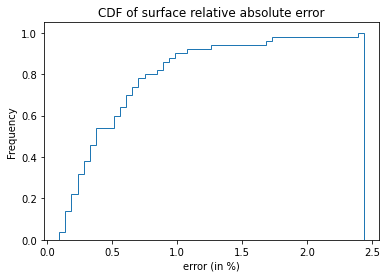

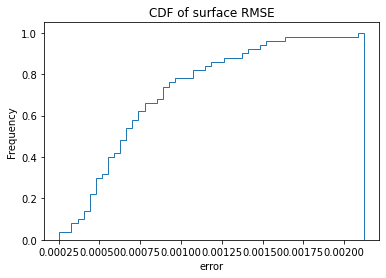

In [26]:
# plot the CDF of absolute relative error and RMSE

calibration_results['Absolute relative error (%)'].plot.hist(cumulative=True, density = True, bins = N, histtype = 'step')
plt.title('CDF of surface relative absolute error')
plt.xlabel('error (in %)')
plt.show()

calibration_results['RMSE'].plot.hist(cumulative=True, density = True, bins = N, histtype = 'step')
plt.title('CDF of surface RMSE')
plt.xlabel('error')
plt.show()

The results are rather satisfying. The relative error (in %) gives a good idea of the calibration accuracy. It is below 1% for 90% of the data and does not go very high for the remaining data as its maximum is 2.50%. We note that the accuracy of the calibration could be increased by having more initial guesses.

Below, we look at the absolute relative errors on the different calibrated parameters.

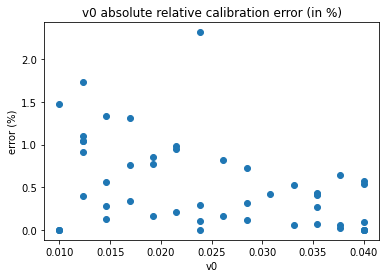

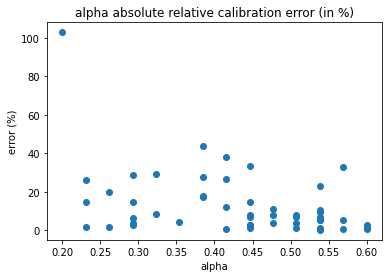

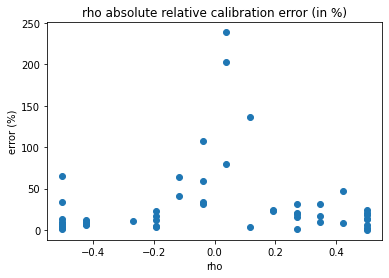

In [27]:
plt.scatter(x = calibration_results['v0'], y = calibration_results['v0_re'])
plt.title('v0 absolute relative calibration error (in %)')
plt.xlabel('v0')
plt.ylabel('error (%)')
plt.show()

plt.scatter(x = calibration_results['alpha'], y = calibration_results['alpha_re'])
plt.title('alpha absolute relative calibration error (in %)')
plt.xlabel('alpha')
plt.ylabel('error (%)')
plt.show()

plt.scatter(x = calibration_results['rho'], y = calibration_results['rho_re'])
plt.title('rho absolute relative calibration error (in %)')
plt.xlabel('rho')
plt.ylabel('error (%)')
plt.show()

The calibration error for parameter $v_0$ is rather small compared to that of $\alpha$ and $\rho$.

The absolute relative error for parameter $\rho$ is huge near 0, but the relative error is not very meaningful for parameters close to zero. Otherwise, its relative error is contained approximately between the same bounds of $\alpha$'s.

Good prediction of $v_0$ is of utmost importance to obtain low surface error. This is because $v_0$ governs the level of the surface.

Estimated (left) and True (right) surfaces:


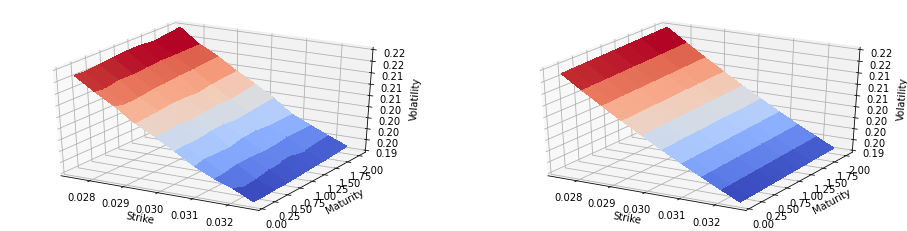

Relative error: 0.1339420596944016 %

Estimated (left) and True (right) surfaces:


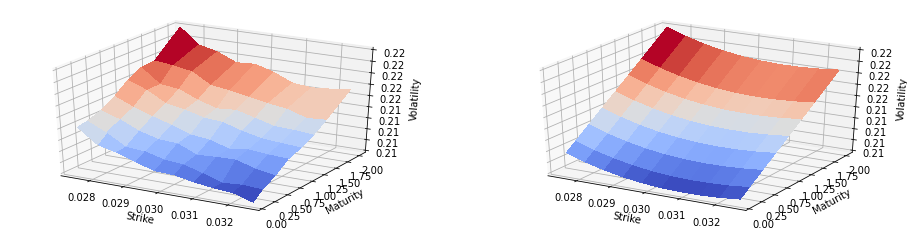

Relative error: 0.30420466172632915 %

Estimated (left) and True (right) surfaces:


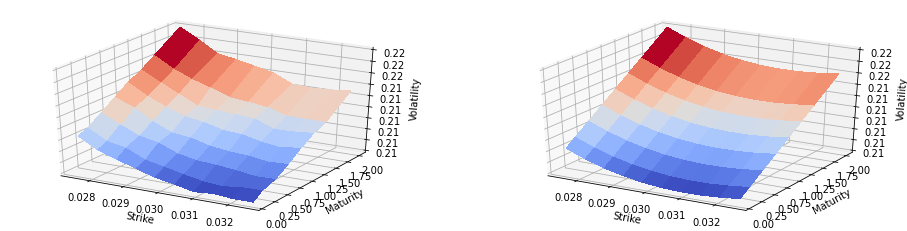

Relative error: 0.35269427466846165 %

Estimated (left) and True (right) surfaces:


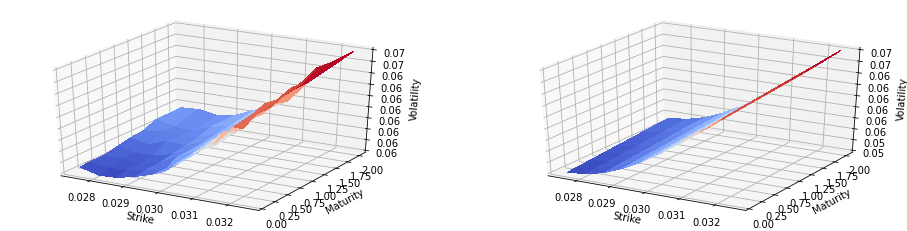

Relative error: 2.0814509999975317 %

Estimated (left) and True (right) surfaces:


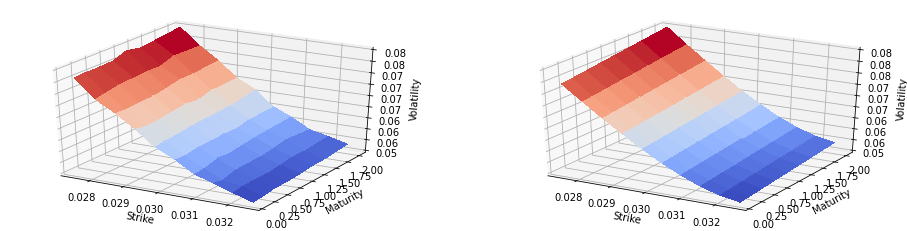

Relative error: 0.9288087170232582 %



In [28]:
nb_plot = 5
for k in range(nb_plot):
    true_s0 = I_test[k*200, 3]
    true_surface = O_test[k*200, :]
    calibrated_param = calibrate(true_s0, true_surface, n_guesses)
    estimated_surface = real_nn(np.append(calibrated_param, true_s0))
    r_error = np.mean(np.abs((estimated_surface - true_surface)/true_surface))*100
    print('Estimated (left) and True (right) surfaces:')
    plot_surfaces([estimated_surface, true_surface], K, T)
    print('Relative error:',r_error,'%\n')

To better see the final result of our algorithm, we plotted above the estimated surface from the estimated parameters obtained via our calibration procedure. We can see that the network and the calibration procedure work fine together and allow to reproduce different shapes of volatility surface. The lack of smoothing in the predicted surface comes from the network, as we already observed on our test sample. The range of the surface is well reproduced as $v_0$ is very well predicted. We observe small discrepancies in the skew and term structure shape that we did not observe before (with the network alone). This comes from the quite high relative error of $\alpha$ and $\rho$ in the calibration process. As said before, the relative error between the surfaces is very limited and the surfaces were taken here in a wide range of the total test sample. This strengthens our analysis of the calibration procedure above.